# Banking Deserts
---
The below script uncovers the well-known phenomenon of [Banking Deserts](https://en.wikipedia.org/wiki/Banking_desert). The concept is simple: many neighborhoods with predominantly low-income and elderly populations tend to have inadequate coverage of banking services. This leads such communities to be  vulnerable to predatory loan and pricey check casher providers.

In this script, we retrieved and plotted data from the 2013 US Census and Google Places API to show the relationship between various socioeconomic parameters and bank count across 700 randomly selected zip codes. We used Pandas, Numpy, Matplotlib, Requests, Census API, and Google API to accomplish our task.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import requests
import time

# Google Places API Key
from config import gkey

## Data Retrieval

In [2]:
# Import the census data into a pandas DataFrame
census_pd = pd.read_csv("Census_Data.csv")

# Preview the data
census_pd.head()

,Zipcode,Address,Population,Median Age,Household Income,Per Capita Income,Poverty Rate
0,15081,"South Heights, PA 15081, USA",342,50.2,31500.0,22177,20.760234
1,20615,"Broomes Island, MD 20615, USA",424,43.4,114375.0,43920,5.188679
2,50201,"Nevada, IA 50201, USA",8139,40.4,56619.0,28908,7.777368
3,84020,"Draper, UT 84020, USA",42751,30.4,89922.0,33164,4.392880
4,39097,"Louise, MS 39097, USA",495,58.0,26838.0,17399,34.949495


In [3]:
# Randomly select 700 zip codes locations that have at least 100 residents
selected_zips = census_pd.sample(n=500)
selected_zips = selected_zips[selected_zips["Population"].astype(int) > 100]

# Visualize
# selected_zips.count()
selected_zips.head()

,Zipcode,Address,Population,Median Age,Household Income,Per Capita Income,Poverty Rate
509,15018,"Buena Vista, PA 15018, USA",668,44.1,50588.0,20773,13.323353
180,84116,"Salt Lake City, UT 84116, USA",33574,29.2,42235.0,15888,21.272413
43,63039,"Gray Summit, MO 63039, USA",1297,31.7,44521.0,18539,4.703161
304,92843,"Garden Grove, CA 92843, USA",44351,33.3,51991.0,17186,20.319722
48,79345,"Meadow, TX 79345, USA",968,41.1,53281.0,22971,17.355372


In [4]:
# Create blank columns for necessary fields
selected_zips["Lat"] = ""
selected_zips["Lng"] = ""

# set up params
params = {
    "key": gkey
}

# Counter
row_count = 0

# Loop through and grab the lat/lng using Google maps
for index, row in selected_zips.iterrows():

    # update params with zipcode each loop
    params['address'] = row['Address']

    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    # Print log to ensure loop is working correctly
    #print("Now retrieving city # " + str(row_count))
    row_count += 1

    # Run requests to grab the JSON at the requested URL
    zip_location = requests.get(base_url, params=params)
    #print(zip_location.url)
    zip_location = zip_location.json()

    # Append the lat/lng to the appropriate columns
    # Use try / except to skip any cities with errors
    try:
        zip_lat = zip_location["results"][0]["geometry"]["location"]["lat"]
        zip_lng = zip_location["results"][0]["geometry"]["location"]["lng"]

        selected_zips.at[index, 'Lat'] = zip_lat
        selected_zips.at[index, 'Lng'] = zip_lng

    except (KeyError, IndexError):
        pass

# Visualize
selected_zips.head()

,Zipcode,Address,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Lat,Lng
509,15018,"Buena Vista, PA 15018, USA",668,44.1,50588.0,20773,13.323353,40.2868,-79.7876
180,84116,"Salt Lake City, UT 84116, USA",33574,29.2,42235.0,15888,21.272413,40.8038,-112.024
43,63039,"Gray Summit, MO 63039, USA",1297,31.7,44521.0,18539,4.703161,38.4977,-90.8437
304,92843,"Garden Grove, CA 92843, USA",44351,33.3,51991.0,17186,20.319722,33.7675,-117.942
48,79345,"Meadow, TX 79345, USA",968,41.1,53281.0,22971,17.355372,33.337,-102.207


In [5]:
# Create an empty column for bank count
selected_zips["Bank Count"] = ""

# Loop through and run Google search to get all banks in 5 mile radius (8000 meters)
# Set up params
params = {
    "radius": 8000,
    "type": "bank",
    "key": gkey
}

# Counter
row_count = 0

for index, row in selected_zips.iterrows():

    # Get lat/lng from df
    lat = row['Lat']
    lng = row['Lng']

    # Update params
    params['location'] = f"{lat},{lng}"

    # Create endpoint url using Google Places Radar and the lat/lng we identified earlier
    base_url = "https://maps.googleapis.com/maps/api/place/radarsearch/json"

    # This link helps to handily see the JSON generated for each query
    #print("Now retrieving city #%s: %s" %(row_count, selected_zips.loc[index]["Address"]))
    row_count += 1

    # Run a request, print the url, and convert to json
    bank_data = requests.get(base_url, params=params)
    #print(bank_data.url)
    bank_data = bank_data.json()

    # Measure bank count on the number of results in the retrieved area
    bank_count = len(bank_data["results"])

    #print("Final Bank Count: " + str(bank_count))
    #print("")

    # Store the bank count into the Data Frame
    selected_zips.at[index, 'Bank Count'] = bank_count

    # Reset bank_count (so there is no chance that a previous record is influencing a latter one)
    bank_count = 0

# Visualize
selected_zips.head()

,Zipcode,Address,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Lat,Lng,Bank Count
509,15018,"Buena Vista, PA 15018, USA",668,44.1,50588.0,20773,13.323353,40.2868,-79.7876,13
180,84116,"Salt Lake City, UT 84116, USA",33574,29.2,42235.0,15888,21.272413,40.8038,-112.024,10
43,63039,"Gray Summit, MO 63039, USA",1297,31.7,44521.0,18539,4.703161,38.4977,-90.8437,7
304,92843,"Garden Grove, CA 92843, USA",44351,33.3,51991.0,17186,20.319722,33.7675,-117.942,169
48,79345,"Meadow, TX 79345, USA",968,41.1,53281.0,22971,17.355372,33.337,-102.207,0


## Save DataFrame

In [7]:
# Save the DataFrame as a csv
selected_zips.to_csv("zip_bank_data_n500.csv",
                     encoding="utf-8", index=False)

## Plot & Save Graphs

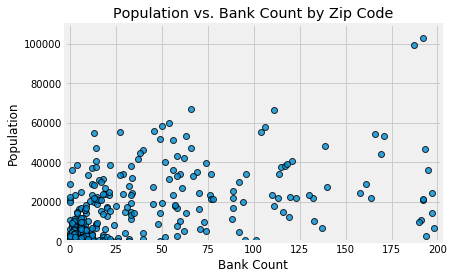

In [9]:
# Build a scatter plot for each data type
plt.scatter(selected_zips["Bank Count"],
            selected_zips["Population"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Zip Codes")

# Incorporate the other graph properties
plt.title("Population vs. Bank Count by Zip Code")
plt.ylabel("Population")
plt.xlabel("Bank Count")
plt.grid(True)
plt.xlim([-2.5, 202])
plt.ylim([-2.5, 110000])

# Save the figure
plt.savefig("Population_BankCount_n500.png")

# Show plot
plt.show()

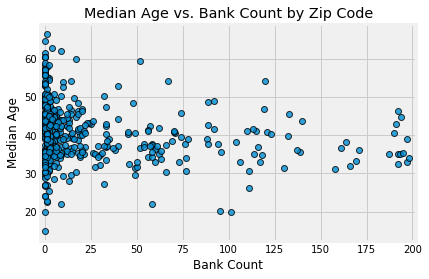

In [10]:
# Build a scatter plot for each data type
plt.scatter(selected_zips["Bank Count"],
            selected_zips["Median Age"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Zip Codes")

# Incorporate the other graph properties
plt.title("Median Age vs. Bank Count by Zip Code")
plt.ylabel("Median Age")
plt.xlabel("Bank Count")
plt.grid(True)
plt.xlim([-2.5, 202])

# Save the figure
plt.savefig("Age_BankCount_n500.png")

# Show plot
plt.show()

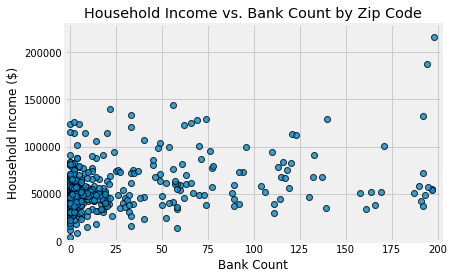

In [11]:
# Build a scatter plot for each data type
plt.scatter(selected_zips["Bank Count"],
            selected_zips["Household Income"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Zip Codes")

# Incorporate the other graph properties
plt.title("Household Income vs. Bank Count by Zip Code")
plt.ylabel("Household Income ($)")
plt.xlabel("Bank Count")
plt.grid(True)
plt.xlim([-2.5, 202])
plt.ylim([-2.5, 230000])

# Save the figure
plt.savefig("HouseholdIncome_BankCount_n500.png")

# Show plot
plt.show()

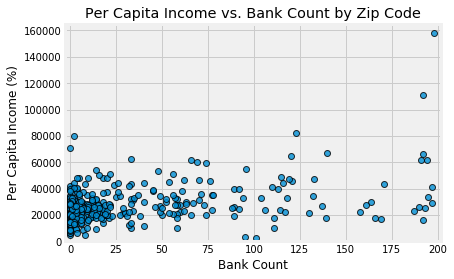

In [12]:
# Build a scatter plot for each data type
plt.scatter(selected_zips["Bank Count"],
            selected_zips["Per Capita Income"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Zip Codes")

# Incorporate the other graph properties
plt.title("Per Capita Income vs. Bank Count by Zip Code")
plt.ylabel("Per Capita Income (%)")
plt.xlabel("Bank Count")
plt.grid(True)
plt.xlim([-2.5, 202])
plt.ylim([0, 165000])

# Save the figure
plt.savefig("PerCapitaIncome_BankCount_n500.png")

# Show plot
plt.show()

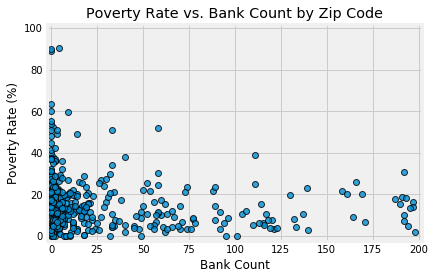

In [13]:
# Build a scatter plot for each data type
plt.scatter(selected_zips["Bank Count"],
            selected_zips["Poverty Rate"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Zip Codes")

# Incorporate the other graph properties
plt.title("Poverty Rate vs. Bank Count by Zip Code")
plt.ylabel("Poverty Rate (%)")
plt.xlabel("Bank Count")
plt.grid(True)
plt.xlim([-2.5, 202])
plt.ylim([-2.5, 102])

# Save the figure
plt.savefig("PovertyRate_BankCount_n500.png")

# Show plot
plt.show()